In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import seaborn as sn
from tqdm import tqdm
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
from utilities import LrUtilities
import torch.nn.functional as F


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_data = torchvision.datasets.CIFAR10(root="data/",download=True, train=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root="data/",download=True, train=False, transform=transform)
classes = ("Airplanes", "Cars", "Birds", "Cats", "Deer", "Dogs", "Frogs", "Horses", "Ships", "Trucks")

Files already downloaded and verified
Files already downloaded and verified


In [4]:
display_data = torchvision.datasets.CIFAR10(root="data/",download=True, train=True)

Files already downloaded and verified


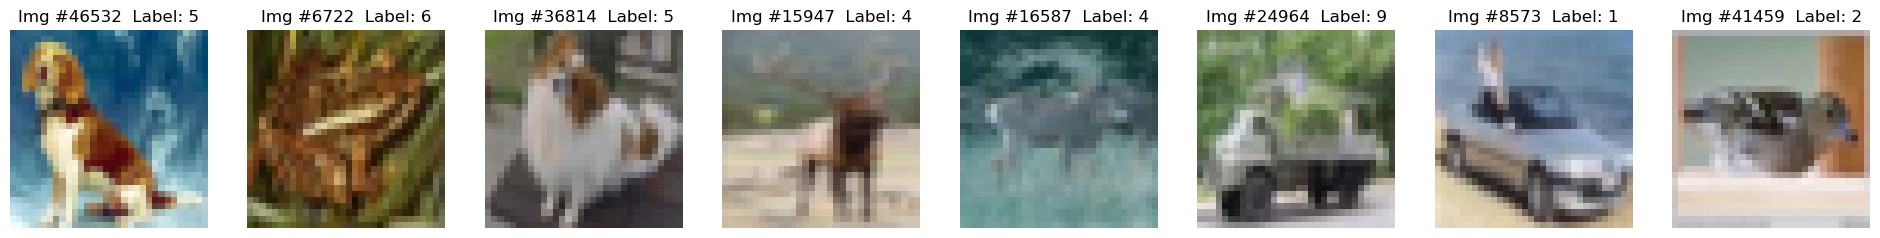

In [5]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_data), size=N_IMGS)

for i, n in enumerate(ids):
    img = display_data[n][0]#.numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {display_data[n][1]}")
    ax[i].axis("off")
plt.show()

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Base Model

In [81]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1,padding=1)
        self.pool = torch.nn.MaxPool2d(2,stride=2)
        self.fc1 = torch.nn.Linear(256 * 4 * 4, 128)  # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10)  # 10 output classes for CIFAR-10
        return
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x,start_dim=1,end_dim=-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [82]:
model = CNN_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model,device,criterion,optimizer)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.10400.: 100%|██████████| 1563/1563 [00:10<00:00, 144.26it/s]


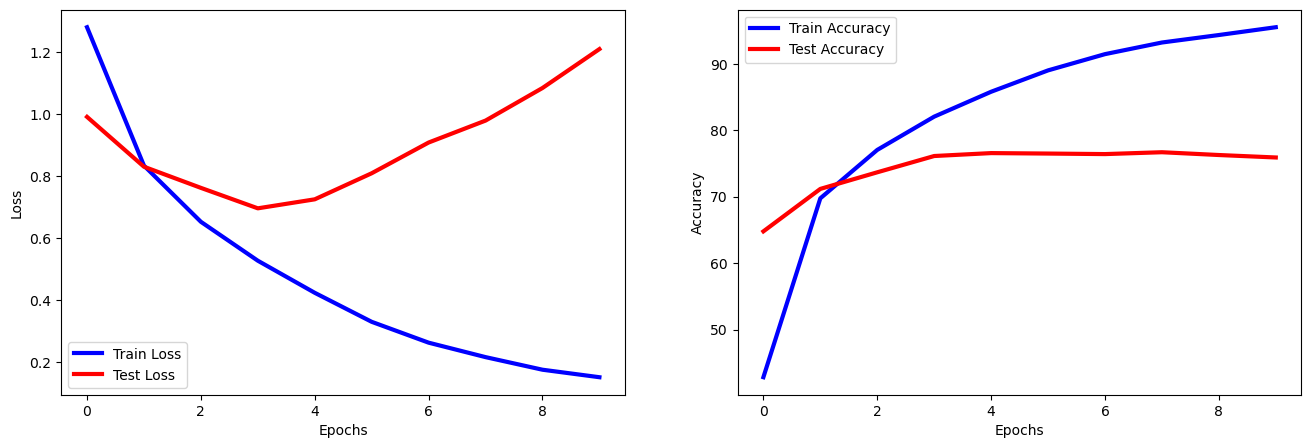

In [83]:
train.plot_loss_acc()

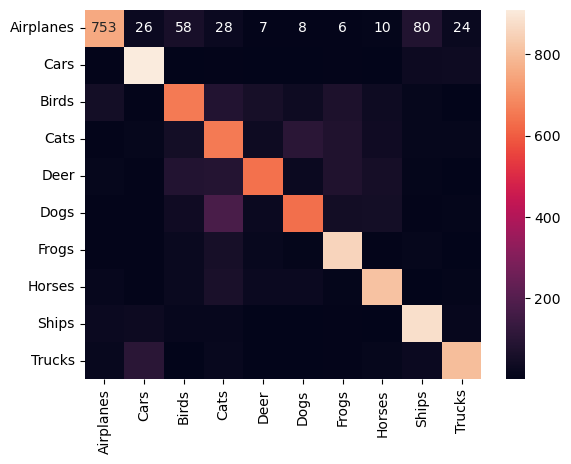

<Figure size 1200x700 with 0 Axes>

In [84]:
train.confusion_matrix() 

In [85]:
train.valid_accuracy()

Validation accuracy: 75.9%


In [86]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Helper function to visualize convolutional kernels
def visualize_kernels(weights, num_kernels=6):
    # Weights have shape [out_channels, in_channels, kernel_size, kernel_size]
    # Take only the first num_kernels filters to visualize
    fig, axes = plt.subplots(1, num_kernels, figsize=(20, 5))
    for i in range(num_kernels):
        kernel = weights[i].detach().cpu().numpy()
        kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())  # normalize for visualization
        axes[i].imshow(kernel.transpose(1, 2, 0))
        axes[i].axis('off')
    plt.show()

# Helper function to visualize activations
def visualize_activations(feature_maps):
    num_feature_maps = feature_maps.size(1)
    fig, axes = plt.subplots(1, min(6, num_feature_maps), figsize=(20, 5))
    for i in range(min(6, num_feature_maps)):
        activation_map = feature_maps[0, i].detach().cpu().numpy()
        axes[i].imshow(activation_map, cmap='viridis')
        axes[i].axis('off')
    plt.show()

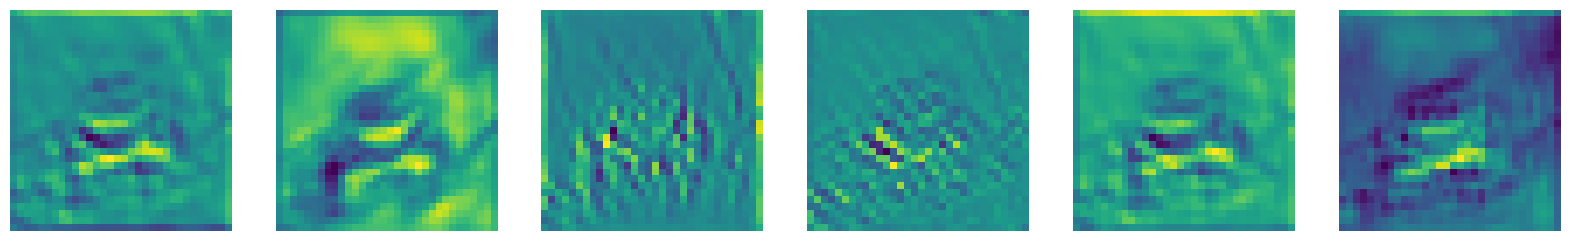

In [88]:
# Define a hook function to get activations
activations = {}

def hook_fn(module, input, output):
    activations['value'] = output

# Register the hook to the layer you want to visualize
hook = model.conv1.register_forward_hook(hook_fn)  # Replace with desired layer

# Forward pass an example image
example_image, _ = next(iter(trainloader))  # Get a single batch from CIFAR-10 DataLoader
example_image = example_image[0].unsqueeze(0).to(device)  # Get one image and add batch dimension

# Forward pass through the model
model(example_image)

# Visualize the activations from the hooked layer
visualize_activations(activations['value'])

# Remove the hook
hook.remove()

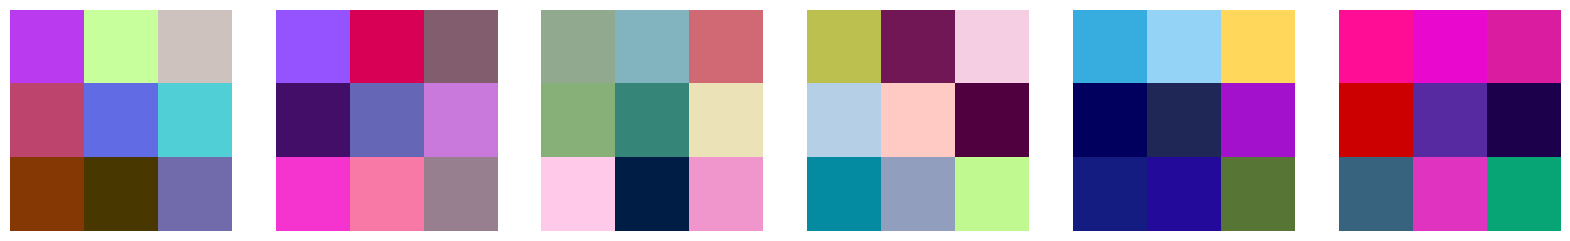

In [92]:
conv1_weights = model.conv1.weight  
visualize_kernels(conv1_weights, num_kernels=6)

## With DropOut

In [32]:
class CNN_WDrop_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_WDrop_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1,padding=1)
        self.pool = torch.nn.MaxPool2d(2,stride=2)
        self.fc1 = torch.nn.Linear(256 * 4 * 4, 128)  # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10)  # 10 output classes for CIFAR-10

        # Dropout layers with a dropout probability 
        self.dropout_conv = torch.nn.Dropout(0.7)  # Applied after convolutional layers
        self.dropout_fc = torch.nn.Dropout(0.5)     # Applied after fully connected layer
        return
    
    def forward(self, x):
        # Convolutional layers with dropout after each conv layer
        x = torch.relu(self.conv1(x))
        x = self.pool(self.dropout_conv(x))  
        
        x = torch.relu(self.conv2(x))
        x = self.pool(self.dropout_conv(x))  
        
        x = torch.relu(self.conv3(x))
        x = self.pool(self.dropout_conv(x)) 

        # Flatten layer
        x = torch.flatten(x, start_dim=1, end_dim=-1)

        # Fully connected layers with dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)  
        x = self.fc2(x)

        return x

In [33]:
model = CNN_WDrop_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train = Wrapper(model,device,criterion,optimizer)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.20188.: 100%|██████████| 1563/1563 [00:13<00:00, 119.80it/s]


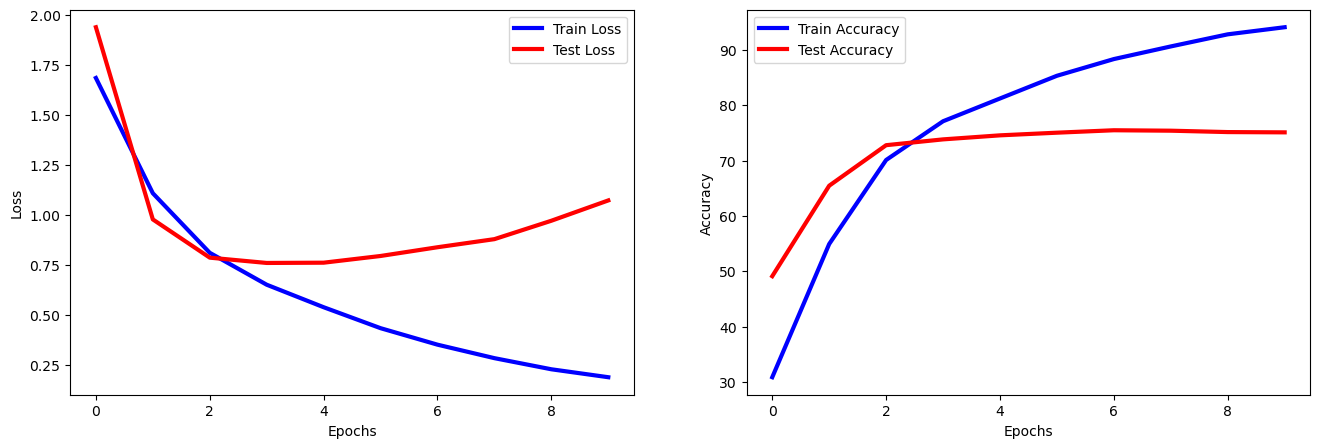

In [34]:
train.plot_loss_acc()

In [35]:
train.valid_accuracy()

Validation accuracy: 75.11%


Dropout regularization was added to reduce overfitting.
Accuracy remained stable at nearly 75%, while the validation loss reduced, indicating better generalization.<br>
thus, The addition of dropout effectively reduced overfitting, as evidenced by the decrease in validation loss. Training stability improved, with minimal impact on accuracy.

## With L2-norm

In [52]:
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=128,kernel_size=3,stride=1,padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1,padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.pool = torch.nn.MaxPool2d(2,stride=2)
        self.fc1 = torch.nn.Linear(1024 * 4 * 4, 128)  # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10)  # 10 output classes for CIFAR-10
        return
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = torch.flatten(x,start_dim=1,end_dim=-1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
model = CNN_Model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay =0.009)
train = Wrapper(model,device,criterion,optimizer)
train.train(20,trainloader,testloader,classes)

Epoch 20 Iter 1563: loss 0.79015.: 100%|██████████| 1563/1563 [00:13<00:00, 116.24it/s]


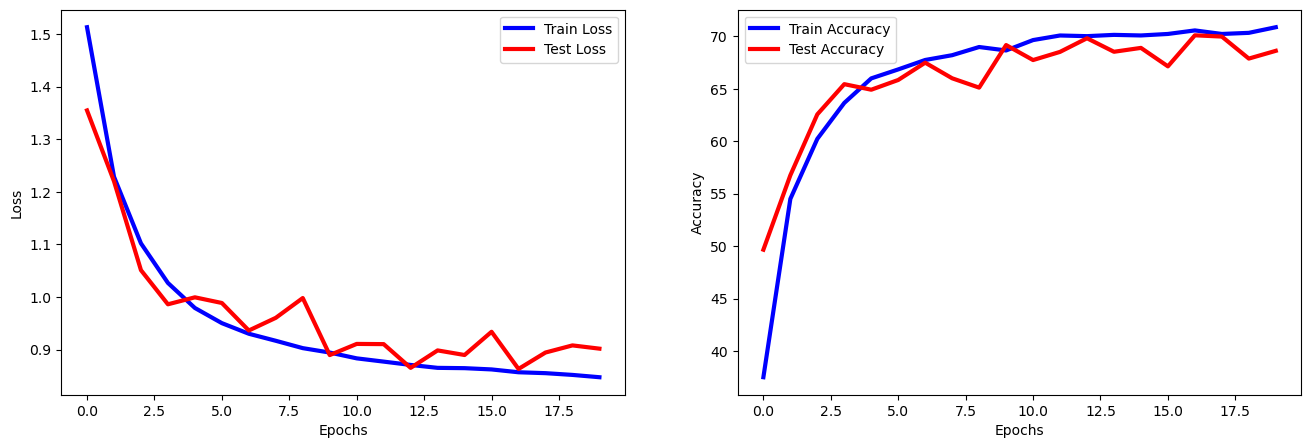

In [75]:
train.plot_loss_acc()

In [77]:
train.valid_accuracy()

Validation accuracy: 68.63%


With L2 regularization, the training loss decreases more gradually where The difference between training and test loss is reduced, indicating better generalization.

## with warmup scheduler

In [154]:
model = CNN_Model().to(device)
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = LrUtilities.WarmupScheduler(optimizer= opt,steps = 10)
train = Wrapper(model = model,device = device,criterion = crit,optimizer = opt,warmup_lr =scheduler)
train.train(20,trainloader,testloader,classes)

Epoch 20 Iter 1563: loss 0.17043.: 100%|██████████| 1563/1563 [00:11<00:00, 134.21it/s]


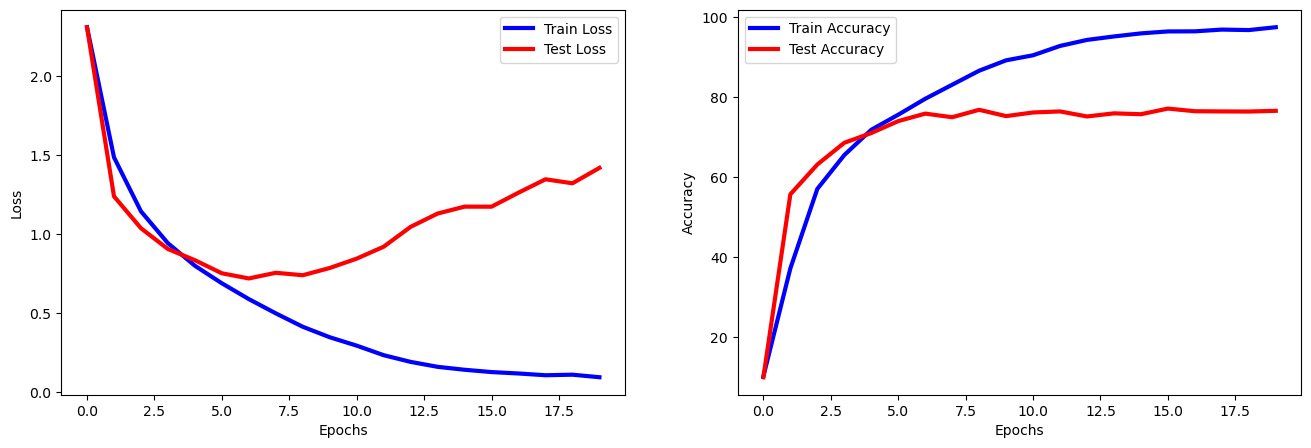

In [155]:
train.plot_loss_acc()

In [156]:
train.valid_accuracy()

Validation accuracy: 76.51%


Training with a warmup scheduler improved model performance and stability in the early stages of training by gradually increasing the learning rate from a small value to a predefined maximum over a set number of steps or epochs, Allowing the model to ease into training, reducing oscillations. This approach helps in mitigating model instability or divergence that sometimes occurs when starting with a high learning rate, thus impoving generalization , in addition to the accuracy obtained 

## with Cosine Annealing scheduler

In [139]:
model = CNN_Model().to(device)
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
sched = LrUtilities.CosineAnnealing(optimizer= opt)
train = Wrapper(model = model,device = device,criterion = crit,optimizer = opt,scheduler =sched)
train.train(20,trainloader,testloader,classes)

Epoch 20 Iter 1563: loss 0.16755.: 100%|██████████| 1563/1563 [00:12<00:00, 126.25it/s]


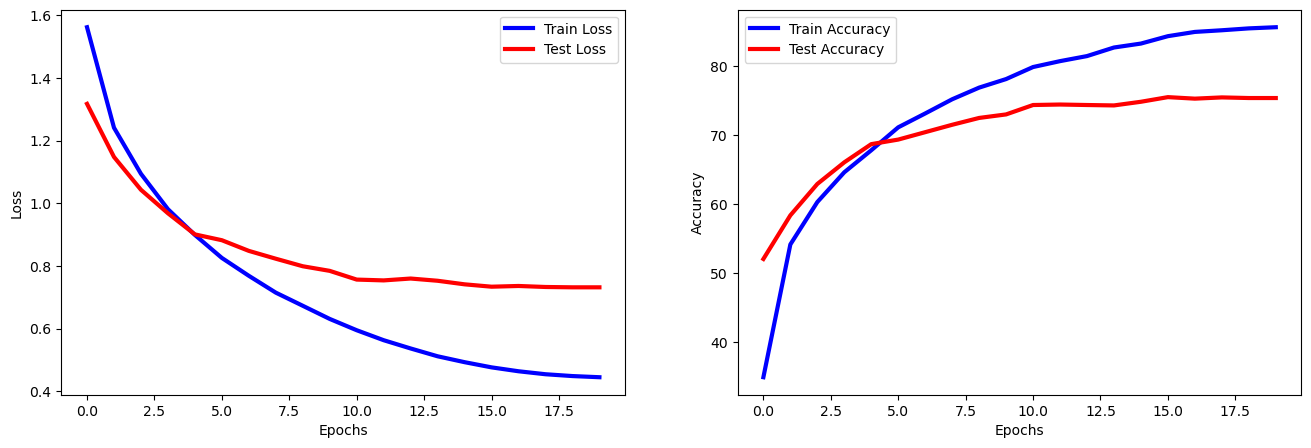

In [140]:
train.plot_loss_acc()

In [141]:
train.valid_accuracy()

Validation accuracy: 75.34%


The cosine annealing scheduler gradually reduces the learning rate following a cosine curve, allowing the model to start with a relatively high learning rate that decreases over time. This helps the model explore the parameter space effectively at the beginning of training while refining its learning as it converges.

## Bonus ConvMixer

In [145]:
class ConvMixer(torch.nn.Module):
    def __init__(self,filters=256 , depth=8 , kernal=5 , patch_size=2 ):
        super().__init__()
        self.d = depth
        self.bn = torch.nn.BatchNorm2d(filters)
        self.cnn1 = torch.nn.Conv2d(3 , filters , (patch_size , patch_size) , stride=patch_size)
        self.bn1 = torch.nn.BatchNorm2d(filters)
        self.cnn2 = torch.nn.Conv2d(filters , filters , (kernal , kernal) , groups=filters , padding="same")
        self.bn2 = torch.nn.BatchNorm2d(filters)
        self.cnn3 = torch.nn.Conv2d(filters , filters , (1,1))
        self.pool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(filters , 10)

    def forward(self , x):
        x = self.bn(F.gelu(self.cnn1(x)))
        for i in range(self.d):
          x = self.bn1(F.gelu(self.cnn2(x)))+ x #residual step and depthwise convolution
          x = self.bn2(F.gelu(self.cnn3(x))) #pointwise convolution
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        return x

In [146]:
model = ConvMixer().to(device)
crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
train = Wrapper(model = model,device = device,criterion = crit,optimizer = opt)
train.train(10,trainloader,testloader,classes)

Epoch 10 Iter 1563: loss 0.49245.: 100%|██████████| 1563/1563 [00:22<00:00, 69.18it/s]


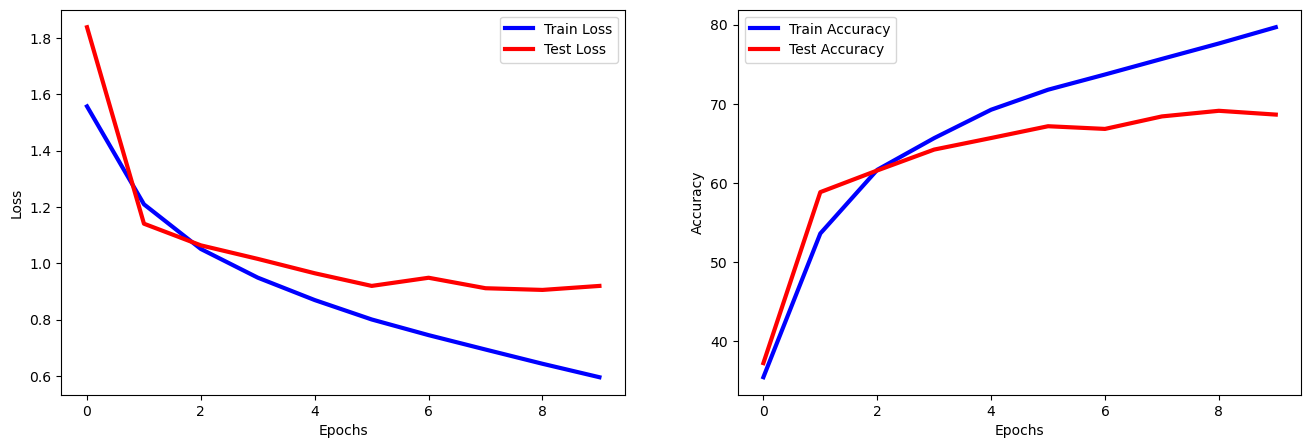

In [147]:
train.plot_loss_acc()

In [123]:
train.valid_accuracy()

Validation accuracy: 75.61%


When comparing the ConvMixer model with our baseline model, we observe an improvement in generalization, even though both models achieved an accuracy of 75%. This suggests that the ConvMixer is better at capturing underlying patterns in the data, leading to enhanced performance on unseen examples